## Quantitative Data Analysis of Hourly Rental Bikes Count

## Problem Statement: Determine the total rental bikes on hourly basis

### Import libraries

In [1]:
import time
import pandas as pd
import numpy as np
from math import sqrt
from sklearn import tree
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Read the csv

In [3]:
df = pd.read_csv('/Users/kangkan/Datasets/Bike-Sharing-Dataset/hour.csv') 
df.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


### Coorelation Matrix

The below image shows the correlation matrix. 

The dark color shows the high correlation between the variables and the light colors shows less correlation between the variables.

Example:
- 'cnt' and 'registered' are highly coorelated
- 'cnt' and 'weathersit' are loosely coorelated

In [4]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.00,0.40,0.87,0.49,-0.00,0.01,0.00,-0.00,-0.01,0.14,0.14,0.01,-0.07,0.16,0.28,0.28
season,0.40,1.00,-0.01,0.83,-0.01,-0.01,-0.00,0.01,-0.01,0.31,0.32,0.15,-0.15,0.12,0.17,0.18
yr,0.87,-0.01,1.00,-0.01,-0.00,0.01,-0.00,-0.00,-0.02,0.04,0.04,-0.08,-0.01,0.14,0.25,0.25
mnth,0.49,0.83,-0.01,1.00,-0.01,0.02,0.01,-0.00,0.01,0.20,0.21,0.16,-0.14,0.07,0.12,0.12
hr,-0.00,-0.01,-0.00,-0.01,1.00,0.00,-0.00,0.00,-0.02,0.14,0.13,-0.28,0.14,0.30,0.37,0.39
holiday,0.01,-0.01,0.01,0.02,0.00,1.00,-0.10,-0.25,-0.02,-0.03,-0.03,-0.01,0.00,0.03,-0.05,-0.03
weekday,0.00,-0.00,-0.00,0.01,-0.00,-0.10,1.00,0.04,0.00,-0.00,-0.01,-0.04,0.01,0.03,0.02,0.03
workingday,-0.00,0.01,-0.00,-0.00,0.00,-0.25,0.04,1.00,0.04,0.06,0.05,0.02,-0.01,-0.30,0.13,0.03
weathersit,-0.01,-0.01,-0.02,0.01,-0.02,-0.02,0.00,0.04,1.00,-0.10,-0.11,0.42,0.03,-0.15,-0.12,-0.14
temp,0.14,0.31,0.04,0.20,0.14,-0.03,-0.00,0.06,-0.10,1.00,0.99,-0.07,-0.02,0.46,0.34,0.40


### Heatmap

This will plot the correlation as a heatmap as shown below.

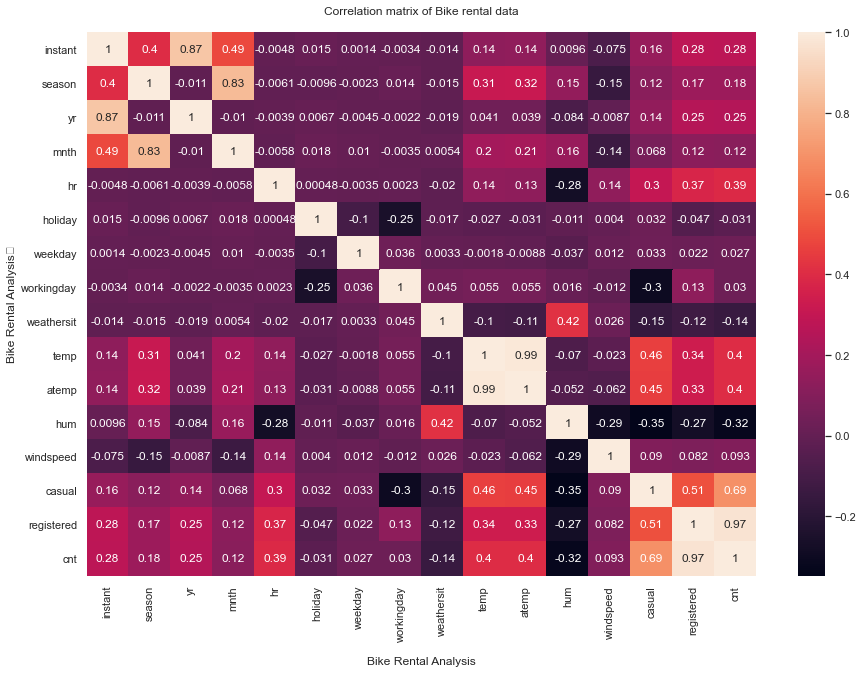

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15, 10)})
hm = sns.heatmap(df.corr(), annot = True)
hm.set(xlabel='\nBike Rental Analysis', ylabel='Bike Rental Analysis\t', title = "Correlation matrix of Bike rental data\n")
plot.show()

### Drop columns that doesn't have much impact on prediction

In [6]:
# 0 = instant   # 1 = dteday   # 2 = season     # 3 = yr          # 4 = mnth   # 5 = hr
# 6 = holiday   # 7 = weekday  # 8 = workingday # 9 = workingday  # 10 = weathersit
# 11 = temp     # 12 = atemp   # 13 = hum       # 14 = windspeed

df = df.drop(df.columns[[0, 1]], axis=1)

### Prepare the predictors and target varaibles

In [7]:
target_column = ['cnt']
predictors = list(set(list(df.columns))-set(target_column))
df[predictors] = df[predictors]/df[predictors].max()
df.head(10)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0.25,0.0,0.083333,0.000000,0.0,1.0,0.0,0.25,0.24,0.2879,0.81,0.000000,0.008174,0.014673,16
1,0.25,0.0,0.083333,0.043478,0.0,1.0,0.0,0.25,0.22,0.2727,0.80,0.000000,0.021798,0.036117,40
2,0.25,0.0,0.083333,0.086957,0.0,1.0,0.0,0.25,0.22,0.2727,0.80,0.000000,0.013624,0.030474,32
3,0.25,0.0,0.083333,0.130435,0.0,1.0,0.0,0.25,0.24,0.2879,0.75,0.000000,0.008174,0.011287,13
4,0.25,0.0,0.083333,0.173913,0.0,1.0,0.0,0.25,0.24,0.2879,0.75,0.000000,0.000000,0.001129,1
5,0.25,0.0,0.083333,0.217391,0.0,1.0,0.0,0.50,0.24,0.2576,0.75,0.105325,0.000000,0.001129,1
6,0.25,0.0,0.083333,0.260870,0.0,1.0,0.0,0.25,0.22,0.2727,0.80,0.000000,0.005450,0.000000,2
7,0.25,0.0,0.083333,0.304348,0.0,1.0,0.0,0.25,0.20,0.2576,0.86,0.000000,0.002725,0.002257,3
8,0.25,0.0,0.083333,0.347826,0.0,1.0,0.0,0.25,0.24,0.2879,0.75,0.000000,0.002725,0.007901,8
9,0.25,0.0,0.083333,0.391304,0.0,1.0,0.0,0.25,0.32,0.3485,0.76,0.000000,0.021798,0.006772,14


### Train and Test Dataset

In [8]:
X = df[predictors].values
y = df[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

(12165, 14)
(5214, 14)


### Tree selection

In [35]:
_no_of_trees = [x*100 for x in range(1, 11)]

In [36]:
# Initialize few variables
_mean_squared_error = []
_mean_absolute_error = []
_R2_score = []
models = {}

### Random Forest Training

In [37]:
# Train for all the trees count
for i in range(len(_no_of_trees)):
    start_time = time.time()
    model_rf = RandomForestRegressor(n_estimators=_no_of_trees[i], oob_score=True, random_state=100)
    model_rf.fit(X_train, y_train)
    models[_no_of_trees[i]] = model_rf
    pred_train_rf= model_rf.predict(X_train)
    elapsed_time = time.time() - start_time
    
    print(f"Training model {i} with no of trees = {_no_of_trees[i]}")
    print("Mean square error: ", np.sqrt(mean_squared_error(y_train,pred_train_rf)))
    print("Mean absolute error: ", np.sqrt(mean_absolute_error(y_train,pred_train_rf)))
    print("R2 score: ", r2_score(y_train, pred_train_rf))
    print(f"Elapsed time for model training: {elapsed_time:.3f} seconds")
    print("================================================")
    
    _mean_squared_error.append(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
    _mean_absolute_error.append(np.sqrt(mean_absolute_error(y_train,pred_train_rf)))
    _R2_score.append(r2_score(y_train, pred_train_rf))

Training model 0 with no of trees = 100
Mean square error:  1.1931461345178291
Mean absolute error:  0.6380946772213608
R2 score:  0.9999568760736368
Elapsed time for model training: 3.692 seconds
Training model 1 with no of trees = 200
Mean square error:  1.118159484583223
Mean absolute error:  0.617834676615389
R2 score:  0.999962126231299
Elapsed time for model training: 7.630 seconds
Training model 2 with no of trees = 300
Mean square error:  1.0968218536963725
Mean absolute error:  0.6109004357304614
R2 score:  0.9999635579156841
Elapsed time for model training: 11.108 seconds
Training model 3 with no of trees = 400
Mean square error:  1.0928414762871443
Mean absolute error:  0.6074575924909383
R2 score:  0.9999638219331248
Elapsed time for model training: 15.087 seconds
Training model 4 with no of trees = 500
Mean square error:  1.0873965443748908
Mean absolute error:  0.6043044664768444
R2 score:  0.9999641815394987
Elapsed time for model training: 19.362 seconds
Training model 

### Plot training curve

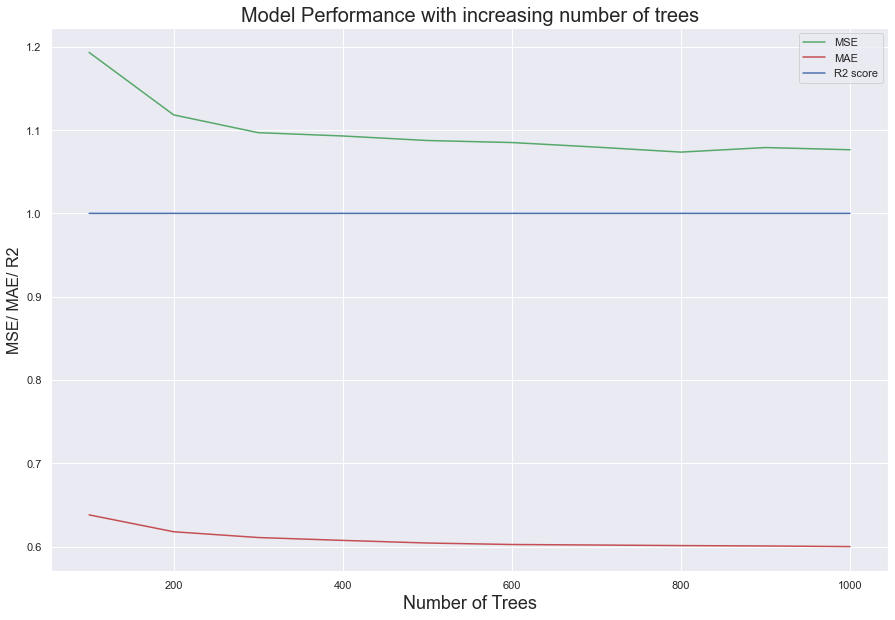

In [38]:
# Plot mean squared error with no pf trees
plt.plot(_no_of_trees, _mean_squared_error, 'g', label='MSE')

# Plot mean absolute error with no of trees
plt.plot(_no_of_trees, _mean_absolute_error, 'r', label='MAE')

# Plor r2 score with no of trees
plt.plot(_no_of_trees, _R2_score, 'b', label='R2 score')

plt.xlabel('Number of Trees', fontsize=18)
plt.ylabel('MSE/ MAE/ R2', fontsize=16)
plt.title("Model Performance with increasing number of trees", fontsize=20)

plt.legend()
plt.show()

### Random Forest Testing

Considering mean absolute error, taking number of trees = 500 as seems suitable from the graph. Beyond this, the models start overfitting.

In [39]:
pred_test_rf = models.get(500).predict(X_test)
print("=======================================")
print ("Test")
print("Mean squared error: ", np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print("Mean absolute error: ", np.sqrt(mean_absolute_error(y_test,pred_test_rf)))
print("R2 score: ", r2_score(y_test, pred_test_rf))

Test
Mean squared error:  2.1243845080790993
Mean absolute error:  0.9366973869024312
R2 score:  0.999861724249826


### Feature Selection

Feature selection relies on correlation analysts to determine the best features we should use; which features (independent variables) have the most statistical influence on helping to determine the target variable (dependent variable). Correlation is a statistical term which refers to how close two variables are, in terms of having a linear relationship with each other. Feature selection is one of the first, and arguably one of the most important steps, when performing any machine learning task. When working with any dataset, we have to understand which column (feature) is going to have a statistically significant impact on the output variable. If we add many irrelevant features into a model, it will just make the model worse. This is why we do feature selection. Pearson's correlation (feature selection) is very popular for determining the relevance of all independent variables, relative to the target variable (dependent variable).

In [41]:
# remove 'cnt' from the list
feature_names = [f"{col}" for col in df.columns][:-1]
result = permutation_importance(
    model_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

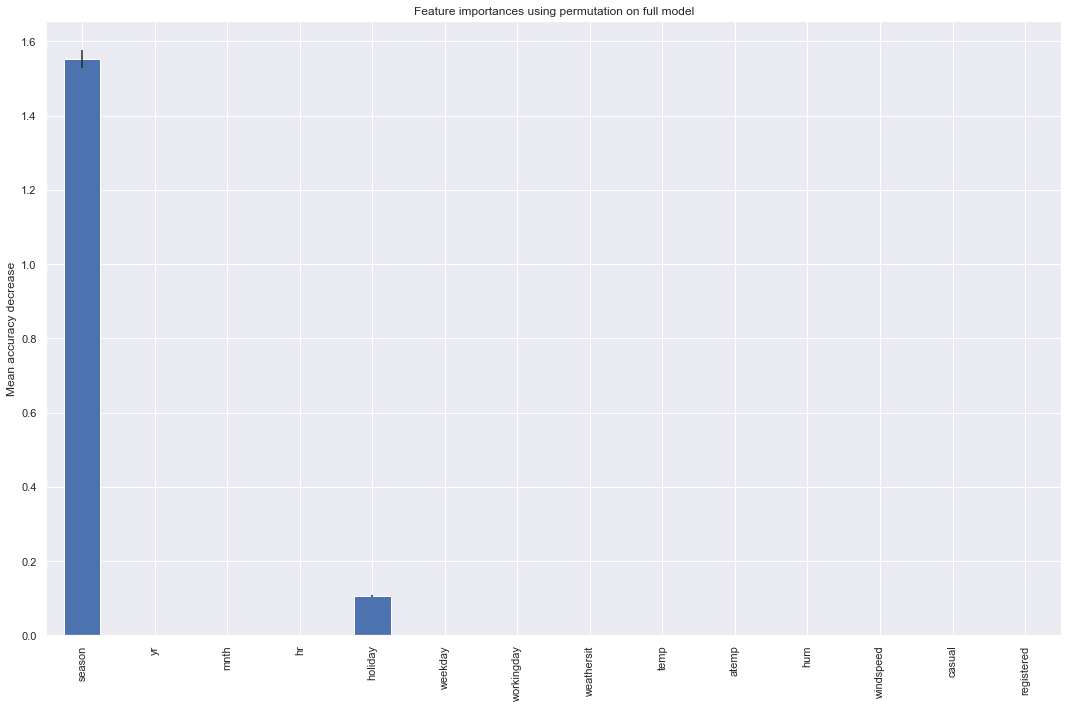

In [42]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [43]:
rfe = RFECV(model_rf,cv=5,scoring="neg_mean_squared_error")
rfe.fit(X_train,y_train)

RFECV(cv=5,
      estimator=RandomForestRegressor(n_estimators=500, oob_score=True,
                                      random_state=100),
      scoring='neg_mean_squared_error')

### Relevant Feature

In [44]:
selected_features = np.array(feature_names)[rfe.get_support()]
print (selected_features)

['season' 'holiday']


### Prediction using only relevant features

In [45]:
pred_test_rfe = rfe.predict(X_test)
print("=======================================")
print ("Test")
print("Mean squared error: ", np.sqrt(mean_squared_error(y_test,pred_test_rfe)))
print("Mean absolute error: ", np.sqrt(mean_absolute_error(y_test,pred_test_rfe)))
print("R2 score: ", r2_score(y_test, pred_test_rfe))

Test
Mean squared error:  1.680732215039863
Mean absolute error:  0.7832791810155249
R2 score:  0.999913448057221
